In [12]:
#### 1. h2o 분석 준비하기 ####
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
%matplotlib inline

h2o.init()
h2o.no_progress()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.20" 2023-07-18; OpenJDK Runtime Environment (build 11.0.20+8-post-Ubuntu-1ubuntu120.04); OpenJDK 64-Bit Server VM (build 11.0.20+8-post-Ubuntu-1ubuntu120.04, mixed mode, sharing)
  Starting server from /home/watercar99/.local/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp2vjg4qrh
  JVM stdout: /tmp/tmp2vjg4qrh/h2o_watercar99_started_from_python.out
  JVM stderr: /tmp/tmp2vjg4qrh/h2o_watercar99_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Asia/Seoul
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.1
H2O_cluster_version_age:,2 months and 1 day
H2O_cluster_name:,H2O_from_python_watercar99_wdi2nt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,29.97 Gb
H2O_cluster_total_cores:,36
H2O_cluster_allowed_cores:,36
H2O_cluster_status:,"locked, healthy"


In [7]:
# 데이터 불러오기
train_data = pd.read_csv("~/project/MIMIC-III/Baseline/overlap/OI/overlap_OI(1%)_train.csv")
test_data = pd.read_csv("~/project/MIMIC-III/Baseline/overlap/OI/overlap_OI(1%)_test.csv")

train_data.rename(columns={'HOSPITAL_EXPIRE_FLAG': 'y'}, inplace=True)
test_data.rename(columns={'HOSPITAL_EXPIRE_FLAG': 'y'}, inplace=True)

train_data.drop(["SUBJECT_ID","HADM_ID", "DOA", "TLOS"], axis=1, inplace=True)
test_data.drop(["SUBJECT_ID","HADM_ID", "DOA", "TLOS"], axis=1, inplace=True)

train_data = pd.get_dummies(train_data, columns=["ETHNICITY", "GENDER"])
test_data = pd.get_dummies(test_data, columns=["ETHNICITY", "GENDER"])

# train_data와 test_data의 칼럼을 맞추기 위해 차집합을 계산
missing_columns_in_test = set(train_data.columns) - set(test_data.columns)
missing_columns_in_train = set(test_data.columns) - set(train_data.columns)

# test_data에 train_data의 더미 변수를 추가하고 0으로 채워주기
for col in missing_columns_in_test:
    test_data[col] = 0

# train_data에 test_data의 더미 변수를 추가하고 0으로 채워주기
for col in missing_columns_in_train:
    train_data[col] = 0

# train_data split
train_data, valid_data, _, _ = train_test_split(train_data, train_data['y'], test_size=0.2, random_state=42)

print("train",len(train_data),"valid",len(valid_data),"test",len(test_data))

train 4532 valid 1134 test 1918


In [9]:
train_data['y'].value_counts()

0    3450
1    1082
Name: y, dtype: int64

In [10]:
valid_data['y'].value_counts()

0    885
1    249
Name: y, dtype: int64

In [11]:
test_data['y'].value_counts()

0    1304
1     614
Name: y, dtype: int64

In [17]:
y = "y"
x = list(train_data.columns)  #if x is defined as all columns except the response, then x is not required
x.remove(y)

h2o_train = h2o.H2OFrame(train_data)
h2o_valid = h2o.H2OFrame(valid_data)
h2o_test = h2o.H2OFrame(test_data)

# For binary classification, response should be a factor
h2o_train[y] = h2o_train[y].asfactor()
h2o_valid[y] = h2o_valid[y].asfactor()
h2o_test[y] = h2o_test[y].asfactor()

In [18]:
################################################################    
## Run AutoML for 120 seconds

aml = H2OAutoML(max_runtime_secs=120, exclude_algos =['StackedEnsemble'])
# aml = H2OAutoML(max_models=5, max_runtime_secs=100000, seed=1 ,include_algos=["gbm"])
aml.train(x = x, y = y, training_frame=h2o_train, leaderboard_frame=h2o_valid)


12:57:04.883: _train param, Dropping bad and constant columns: [ETHNICITY_SOUTH AMERICAN, ETHNICITY_ASIAN - CAMBODIAN, ETHNICITY_HISPANIC/LATINO - COLOMBIAN, ETHNICITY_HISPANIC/LATINO - HONDURAN]


12:57:08.928: _train param, Dropping bad and constant columns: [ETHNICITY_SOUTH AMERICAN, ETHNICITY_ASIAN - CAMBODIAN, ETHNICITY_HISPANIC/LATINO - COLOMBIAN, ETHNICITY_HISPANIC/LATINO - HONDURAN]


12:57:11.134: _train param, Dropping bad and constant columns: [ETHNICITY_SOUTH AMERICAN, ETHNICITY_ASIAN - CAMBODIAN, ETHNICITY_HISPANIC/LATINO - COLOMBIAN, ETHNICITY_HISPANIC/LATINO - HONDURAN]


12:57:13.912: _train param, Dropping bad and constant columns: [ETHNICITY_SOUTH AMERICAN, ETHNICITY_ASIAN - CAMBODIAN, ETHNICITY_HISPANIC/LATINO - COLOMBIAN, ETHNICITY_HISPANIC/LATINO - HONDURAN]


12:57:15.549: _train param, Dropping bad and constant columns: [ETHNICITY_SOUTH AMERICAN, ETHNICITY_ASIAN - CAMBODIAN, ETHNICITY_HISPANIC/LATINO - COLOMBIAN, ETHNICITY_HISPANIC/LATINO - HONDURAN]


12:57:20.

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_1_20230822_125704_model_1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    32                 32                          11760                  6            6            6             12            37            24.5938

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.12525264875140657
RMSE: 0.3539105095238153
LogLoss: 0.40103992324960513
Mean Per-Class Error: 0.21822711564735192
AUC: 0.8715175868627608
AUCPR: 0.7223844886180042
Gini: 0.7430351737255216

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29506614614189736
       0     1     Error    Rate
-----  ----  ----  -------  --------------
0      2955  495   0.1435   (495.0/3450.0)
1      317   765   0.293    (317.0/1082.0)
Total  3272  1260  0.1792   (812.0/4532.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.295066     0.653288  198
max f2                       0.203325     0.742658  264
max f0point5                 0.405303     0.681445  133
max accuracy                 0.361389     0.842674  160
max precision                0.921252     1         0
max recall                   0.0819887    1         369
max specificity              0.921252     1         0
max absolute_mcc             0.353531     0.545355  165
max min_per_class_accuracy   0.255487     0.785582  223
max mean_per_class_accuracy  0.254379     0.786958  224
max tns                      0.921252     3450      0
max fns                      0.921252     1081      0
max fps                      0.0378631    3450      399
max tps                      0.0819887    1082      369
max tnr                      0.921252     1         0
max fnr                      0.921252     0.999076  0
max fpr                      0.0378631    1         399
max tpr                      0.0819887    1         369

Gains/Lift Table: Avg response rate: 23.87 %, avg score: 23.74 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01015                     0.735339           4.18854   4.18854            1                0.792458   1                           0.792458            0.0425139       0.0425139                  318.854   318.854            0.0425139
2        0.0200794                   0.664061           4.00238   4.09648            0.955556         0.694826   0.978022                    0.744179            0.0397412       0.0822551                  300.238   309.648            0.0816754
3        0.0300088                   0.62849            3.81623   4.00375            0.911111         0.649444   0.955882                    0.712833            0.0378928       0.120148                   281.623   300.375            0.118409
4        0.0401589                   0.601302           3.73326   3.93539            0.891304         0.613936   0.93956                     0.687837            0.0378928       0.158041                   273.326   293.539            0.154852
5        0.0500883                   0.570686           3.9093    3.93022            0.933333         0.584322   0.938326           

In [19]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_grid_1_AutoML_1_20230822_125704_model_1,0.726213,0.471861,0.41487,0.31294,0.391013,0.152891
XGBoost_grid_1_AutoML_1_20230822_125704_model_11,0.725401,0.472356,0.400495,0.320216,0.39199,0.153656
XGBoost_3_AutoML_1_20230822_125704,0.722295,0.483327,0.404528,0.328807,0.396118,0.156909
XGBoost_grid_1_AutoML_1_20230822_125704_model_14,0.721625,0.473275,0.409546,0.321666,0.392412,0.153987
DeepLearning_1_AutoML_1_20230822_125704,0.721122,0.498579,0.406433,0.323055,0.404073,0.163275
GBM_grid_1_AutoML_1_20230822_125704_model_13,0.720157,0.476769,0.407927,0.322789,0.392402,0.15398
GBM_1_AutoML_1_20230822_125704,0.718095,0.475239,0.40207,0.326867,0.39279,0.154284
GLM_1_AutoML_1_20230822_125704,0.717968,0.47856,0.396229,0.332448,0.393846,0.155115
GBM_grid_1_AutoML_1_20230822_125704_model_9,0.71508,0.474624,0.417875,0.333483,0.391609,0.153358
GBM_2_AutoML_1_20230822_125704,0.713505,0.480346,0.383309,0.329773,0.395904,0.15674


In [24]:
performance = aml.leader.model_performance(h2o_valid)  # (Optional) Evaluate performance on a test set

model_id   =aml.leader.model_id  # 최고 모델 명
accuracy   =performance.accuracy()  # 정확도
precision  =performance.precision()  # precision
recall     =performance.recall()  # recall
F1         =performance.F1()  # f1
auc        =performance.auc()  # auc
variable_importance=aml.leader.varimp()  # 중요한 입력 변수

# print(model_id, accuracy, precision, recall, F1, auc, variable_importance)
# print(performance)

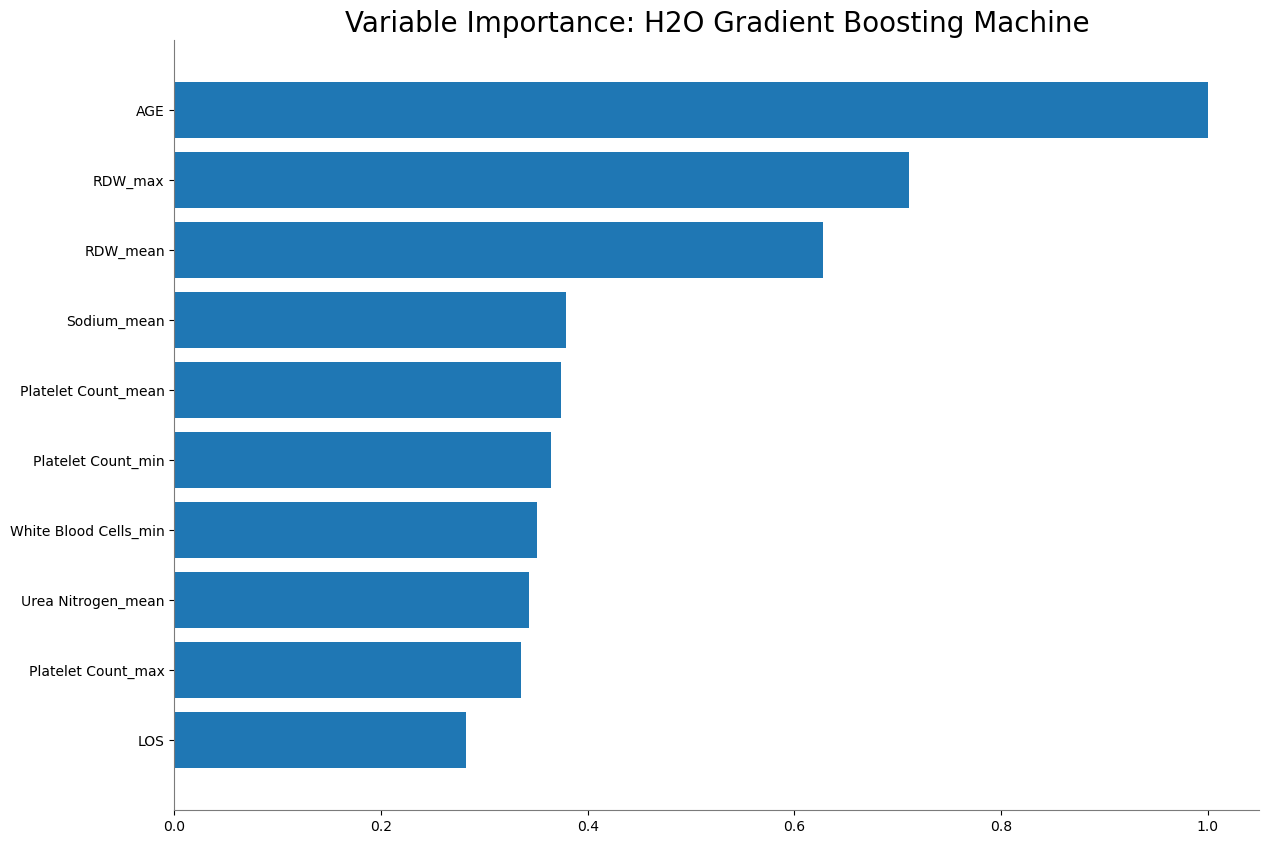

<Figure size 640x480 with 0 Axes>

In [21]:
## 중요 변수 시각화
aml.leader.varimp_plot()

### Test

In [22]:
aml.leader.model_performance(test_data=h2o_test)

ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.19665324253498268
RMSE: 0.4434560209704934
LogLoss: 0.5790484115018285
Mean Per-Class Error: 0.33739583541495977
AUC: 0.7093139875302252
AUCPR: 0.5400092956403134
Gini: 0.41862797506045046

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2080766697367155
       0    1    Error    Rate
-----  ---  ---  -------  --------------
0      766  538  0.4126   (538.0/1304.0)
1      161  453  0.2622   (161.0/614.0)
Total  927  991  0.3644   (699.0/1918.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.208077     0.564486  260
max f2                       0.0947188    0.721873  362
max f0point5                 0.326223     0.52866   171
max accuracy                 0.399744     0.714286  123
max precision                0.862162     1         0
max recall                   0.0558399    1         393
max specificity              0.862162     1         0
max absolute_mcc             0.208077     0.303604  260
max min_per_class_accuracy   0.235271     0.652607  237
max mean_per_class_accuracy  0.208077     0.662604  260
max tns                      0.862162     1304      0
max fns                      0.862162     613       0
max fps                      0.0434152    1304      399
max tps                      0.0558399    614       393
max tnr                      0.862162     1         0
max fnr                      0.862162     0.998371  0
max fpr                      0.0434152    1         399
max tpr                      0.0558399    1         393

Gains/Lift Table: Avg response rate: 32.01 %, avg score: 24.80 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0104275                   0.701667           2.96759   2.96759            0.95             0.776243   0.95                        0.776243            0.0309446       0.0309446                  196.759   196.759            0.0301778
2        0.0203337                   0.642134           2.13732   2.5631             0.684211         0.674525   0.820513                    0.726688            0.0211726       0.0521173                  113.732   156.31             0.0467492
3        0.0302398                   0.595692           2.13732   2.42362            0.684211         0.621374   0.775862                    0.692189            0.0211726       0.0732899                  113.732   142.362            0.0633206
4        0.040146                    0.569981           1.64409   2.23127            0.526316         0.582233   0.714286                    0.665057            0.0162866       0.0895765                  64.4094   123.127            0.0727054
5        0.0500521                   0.544713           2.13732   2.21268            0.684211         0.560007   0.708333                    0.644266            0.0211726       0.110749                   113.732   121.268            0.0892768
6        0.100104                    0.452819           1.78966   2.00117            0.572917         0.491424   0.640625                    0.567845            0.0895765       0.200326                   78.9665   100.117            0.147412
7        0.150156                    0.39838            1.75713   1.91982            0.5625           0.426971   0.614583                    0.520887            0.0879479       0.288274                   75.7125   91.9822            0.203151
8        0.200209                  

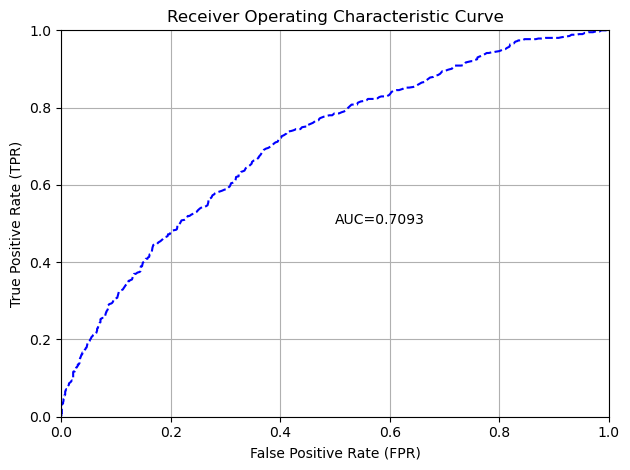

([0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0007668711656441718,
  0.0007668711656441718,
  0.0007668711656441718,
  0.0007668711656441718,
  0.0007668711656441718,
  0.0007668711656441718,
  0.0007668711656441718,
  0.0007668711656441718,
  0.0007668711656441718,
  0.0007668711656441718,
  0.0007668711656441718,
  0.0007668711656441718,
  0.0015337423312883436,
  0.0023006134969325155,
  0.003067484662576687,
  0.003067484662576687,
  0.003834355828220859,
  0.003834355828220859,
  0.003834355828220859,
  0.004601226993865031,
  0.004601226993865031,
  0.004601226993865031,
  0.005368098159509203,
  0.005368098159509203,
  0.006134969325153374,
  0.006901840490797546,
  0.006901840490797546,
  0.006901840490797546,
  0.006901840490797546,
  0.006901840490797546,
  0.007668711656441718,
  0.007668711656441718,
  0.00843558282208589,
  0.009202453987730062,
  0.009969325153374233,
  0.011503067484662576,
  0.011503067484662576,
  0.01303680981595092,
  0.013803680981595092,
  0.0138036809815

In [23]:
%matplotlib inline
aml.leader.model_performance(test_data=h2o_test).plot()

In [3]:
data.drop(["SUBJECT_ID","HADM_ID", "DOA", "TLOS"], axis=1, inplace=True)
# data.drop(["SUBJECT_ID","HADM_ID", "DOA", "TLOS", "height", "weight", "BMI", "hr_mean", "hr_min", "hr_max"], axis=1, inplace=True)
data

,AGE,ETHNICITY,HOSPITAL_EXPIRE_FLAG,GENDER,LOS,Hematocrit,Creatinine,Urea Nitrogen,Platelet Count,White Blood Cells,...,Specific Gravity,Asparate Aminotransferase (AST),Alanine Aminotransferase (ALT),Base Excess,"Bilirubin, Total",Alkaline Phosphatase,Eosinophils,Basophils,Creatine Kinase (CK),Albumin
0,72,WHITE,0,M,4.3483,41.850000,1.100,19.500000,225.000000,16.65,...,0.0000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,342.00,0.0
1,81,WHITE,1,F,3.9715,36.700000,0.750,19.500000,381.000000,11.20,...,0.0000,124.0,33.0,0.000000,0.500000,184.0,0.000000,0.000000,0.00,2.6
2,75,ASIAN,0,M,22.8977,35.900000,0.250,11.000000,384.000000,10.55,...,1.0150,28.0,34.0,14.000000,0.000000,0.0,0.600000,0.050000,0.00,0.0
3,82,ASIAN,1,M,9.8919,34.133333,0.925,16.000000,223.666667,12.00,...,1.0225,68.0,48.5,-9.000000,0.550000,79.0,0.500000,0.500000,772.25,0.0
4,66,WHITE,0,F,10.5708,41.700000,0.600,12.500000,145.500000,11.80,...,1.0200,0.0,0.0,-3.444444,0.000000,0.0,0.800000,0.150000,356.50,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7579,54,BLACK/HAITIAN,0,M,0.8342,31.250000,5.450,60.833333,450.500000,14.65,...,1.0140,0.0,0.0,0.000000,0.000000,0.0,0.300000,0.400000,176.00,0.0
7580,87,BLACK/AFRICAN AMERICAN,1,M,9.1439,20.050000,1.700,41.500000,227.500000,12.35,...,1.0130,28.0,12.0,-3.000000,0.300000,214.0,0.000000,0.000000,135.50,2.9
7581,84,WHITE,0,M,12.0867,37.600000,1.025,22.250000,208.000000,4.00,...,1.0380,37.0,18.0,-5.666667,0.600000,41.0,0.000000,0.000000,115.00,0.0
7582,26,HISPANIC OR LATINO,0,M,2.8780,22.220000,20.200,148.666667,100.600000,9.45,...,1.0120,20.0,22.0,-1.333333,0.633333,70.0,0.766667,0.133333,509.50,3.2


In [4]:
data.columns

Index(['AGE', 'ETHNICITY', 'HOSPITAL_EXPIRE_FLAG', 'GENDER', 'LOS',
       'Hematocrit', 'Creatinine', 'Urea Nitrogen', 'Platelet Count',
       'White Blood Cells', 'Hemoglobin', 'MCHC', 'MCV', 'MCH',
       'Red Blood Cells', 'RDW', 'Potassium', 'Chloride', 'Bicarbonate',
       'Sodium', 'Anion Gap', 'Glucose', 'Magnesium', 'Calcium, Total',
       'Phosphate', 'INR(PT)', 'PT', 'PTT', 'Neutrophils', 'Lymphocytes',
       'Monocytes', 'pH', 'Calculated Total CO2', 'pO2', 'pCO2', 'pH.1',
       'Lactate', 'Specific Gravity', 'Asparate Aminotransferase (AST)',
       'Alanine Aminotransferase (ALT)', 'Base Excess', 'Bilirubin, Total',
       'Alkaline Phosphatase', 'Eosinophils', 'Basophils',
       'Creatine Kinase (CK)', 'Albumin'],
      dtype='object')

In [5]:
#### 1. h2o 분석 준비하기 ####
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
%matplotlib inline
h2o.init()
h2o.no_progress()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.19" 2023-04-18; OpenJDK Runtime Environment (build 11.0.19+7-post-Ubuntu-0ubuntu120.04.1); OpenJDK 64-Bit Server VM (build 11.0.19+7-post-Ubuntu-0ubuntu120.04.1, mixed mode, sharing)
  Starting server from /home/watercar99/.local/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpmvqiaxol
  JVM stdout: /tmp/tmpmvqiaxol/h2o_watercar99_started_from_python.out
  JVM stderr: /tmp/tmpmvqiaxol/h2o_watercar99_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Asia/Seoul
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,5 months and 22 days
H2O_cluster_name:,H2O_from_python_watercar99_ldl4wa
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,29.97 Gb
H2O_cluster_total_cores:,36
H2O_cluster_allowed_cores:,36
H2O_cluster_status:,"locked, healthy"


In [6]:
#### 2. 데이터 불러오기 ####
data.head()
# 데이터 확인
data.describe()

# var2~는 입력 feature
feature = data.drop('HOSPITAL_EXPIRE_FLAG', axis=1)
feature.describe()

# var1은 label
label = data['HOSPITAL_EXPIRE_FLAG']
label.describe()

count    7584.000000
mean        0.256461
std         0.436708
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: HOSPITAL_EXPIRE_FLAG, dtype: float64

In [7]:
## make dataset
# Identify the response and set of predictors
y = "HOSPITAL_EXPIRE_FLAG"
x = list(data.columns)  #if x is defined as all columns except the response, then x is not required
x.remove(y)

# data_df을 8:2로 나눈다
train, valid = train_test_split(data,test_size=0.2, shuffle=True)

In [8]:
h2o_train = h2o.H2OFrame(train)
h2o_valid = h2o.H2OFrame(valid)

# For binary classification, response should be a factor
h2o_train[y] = h2o_train[y].asfactor()
h2o_valid[y] = h2o_valid[y].asfactor()

In [9]:
################################################################    
## Run AutoML for 120 seconds
aml = H2OAutoML(max_runtime_secs=120, exclude_algos =['StackedEnsemble'])
aml.train(x = x, y = y, training_frame=h2o_train, leaderboard_frame=h2o_valid)

Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_grid_1_AutoML_1_20230731_163833_model_6


Model Summary: 
    number_of_trees
--  -----------------
    41

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1141477023020098
RMSE: 0.33785751775269085
LogLoss: 0.37223218850374484
Mean Per-Class Error: 0.1835052662107836
AUC: 0.9055187630414752
AUCPR: 0.8071005408210081
Gini: 0.8110375260829503

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33503346583422494
       0     1     Error    Rate
-----  ----  ----  -------  --------------
0      3998  515   0.1141   (515.0/4513.0)
1      393   1161  0.2529   (393.0/1554.0)
Total  4391  1676  0.1497   (908.0/6067.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.335033     0.718885  187
max f2                       0.238884     0.786382  244
max f0point5                 0.476667     0.771511  123
max accuracy                 0.418526     0.865667  148
max precision                0.915433     1         0
max recall                   0.0545961    1         376
max specificity              0.915433     1         0
max absolute_mcc             0.418526     0.627446  148
max min_per_class_accuracy   0.282971     0.818533  216
max mean_per_class_accuracy  0.272577     0.821934  222
max tns                      0.915433     4513      0
max fns                      0.915433     1553      0
max fps                      0.0189308    4513      399
max tps                      0.0545961    1554      376
max tnr                      0.915433     1         0
max fnr                      0.915433     0.999356  0
max fpr                      0.0189308    1         399
max tpr                      0.0545961    1         376

Gains/Lift Table: Avg response rate: 25.61 %, avg score: 25.41 %
group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ----------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100544                   0.775784           3.90412     3.90412            1                0.814969   1                           0.814969            0.0392535       0.0392535                  290.412   290.412            0.0392535
2        0.0201088                   0.734059           3.64811     3.77611            0.934426         0.752952   0.967213                    0.78396             0.0366795       0.0759331                  264.811   277.611            0.0750467
3        0.0299984                   0.697007           3.90412     3.81831            1                0.712679   0.978022                    0.760461            0.03861         0.114543                   290.412   281.831            0.113657
4        0.0400527                   0.671922           3.77611     3.80772            0.967213         0.685958   0.975309                    0.741759            0.0379665       0.15251                    277.611   280.772            0.15118
5        0.0501071                   0.645914           3.71211     3.78854            0.95082          0.657253   0.970395                    0.724802            0.037323        0.189833                   271.211   278.854            0.187838
6        0.100049                    0.549976           3.53046     3.65971            0.90429          0.596986   0.937397                    0.660999            0.176319        0.366152                   253.046   265.971            0.357732
7        0.149992                    0.47697            2.96352 

In [10]:
leaderboard = aml.leaderboard
performance = aml.leader.model_performance(h2o_valid)  # (Optional) Evaluate performance on a test set

model_id   =aml.leader.model_id  # 최고 모델 명
accuracy   =performance.accuracy()  # 정확도
precision  =performance.precision()  # precision
recall     =performance.recall()  # recall
F1         =performance.F1()  # f1
auc        =performance.auc()  # auc
variable_importance=aml.leader.varimp()  # 중요한 입력 변수

print(model_id, accuracy, precision, recall, F1, auc, variable_importance)
print(performance)

XGBoost_grid_1_AutoML_1_20230731_163833_model_6 [[0.5412178635597229, 0.7738958470665788]] [[0.8379067778587341, 1.0]] [[0.03519121743738651, 1.0]] [[0.22242120280861855, 0.5347985347985348]] 0.7445623781986345 [('AGE', 251.49612426757812, 1.0, 0.06804723984173222), ('Platelet Count', 180.39739990234375, 0.7172969381842671, 0.048810076790364997), ('RDW', 175.9102325439453, 0.6994550435170382, 0.04759598510471315), ('LOS', 165.3659210205078, 0.6575287054704967, 0.04474301352397459), ('Bilirubin, Total', 156.4524688720703, 0.6220869976732263, 0.04233130313309315), ('White Blood Cells', 144.66412353515625, 0.5752141268834884, 0.039141733652393325), ('INR(PT)', 141.4871826171875, 0.5625819603750747, 0.038282149588274604), ('Urea Nitrogen', 122.16474914550781, 0.4857520150709408, 0.03305408387313703), ('Lactate', 114.35128021240234, 0.45468406539235107, 0.030939995649967172), ('pH', 110.3127212524414, 0.4386259294201874, 0.029847283820058204), ('Albumin', 108.74862670898438, 0.4324067697889

In [11]:
for i in variable_importance:
    print(i)

('AGE', 251.49612426757812, 1.0, 0.06804723984173222)
('Platelet Count', 180.39739990234375, 0.7172969381842671, 0.048810076790364997)
('RDW', 175.9102325439453, 0.6994550435170382, 0.04759598510471315)
('LOS', 165.3659210205078, 0.6575287054704967, 0.04474301352397459)
('Bilirubin, Total', 156.4524688720703, 0.6220869976732263, 0.04233130313309315)
('White Blood Cells', 144.66412353515625, 0.5752141268834884, 0.039141733652393325)
('INR(PT)', 141.4871826171875, 0.5625819603750747, 0.038282149588274604)
('Urea Nitrogen', 122.16474914550781, 0.4857520150709408, 0.03305408387313703)
('Lactate', 114.35128021240234, 0.45468406539235107, 0.030939995649967172)
('pH', 110.3127212524414, 0.4386259294201874, 0.029847283820058204)
('Albumin', 108.74862670898438, 0.4324067697889522, 0.029424087173017522)
('PT', 106.51261901855469, 0.42351594613534116, 0.028819091163469705)
('Anion Gap', 102.95661163330078, 0.40937653386562955, 0.02785694318553151)
('Creatinine', 96.11276245117188, 0.3821639905230

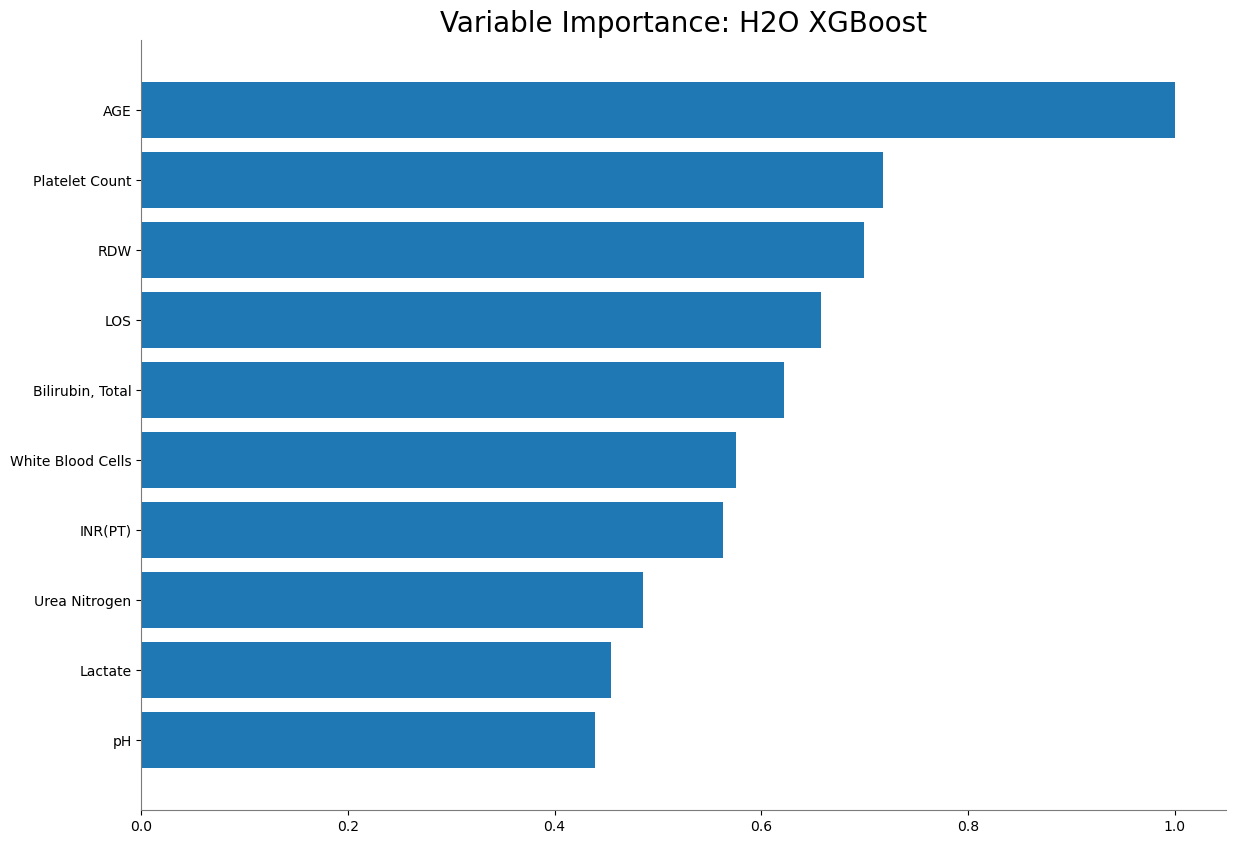

  predict
        0
        0
        0
        0
        0
        0
        1
        0
        0
        0
[1517 rows x 1 column]



H2OResponseError: Server error java.lang.IllegalArgumentException:
  Error: Column var1 not found
  Request: POST /99/Rapids
    data: {'ast': "(tmp= py_10_sid_b0cc (cols_py py_2_sid_b0cc 'var1'))", 'session_id': '_sid_b0cc'}


<Figure size 640x480 with 0 Axes>

In [12]:
## 중요 변수 시각화
aml.leader.varimp_plot()

## automl 결과 확인
# Get AutoML object by `project_name`
get_aml = h2o.automl.get_automl(aml.project_name)
# Predict with top model from AutoML Leaderboard on a H2OFrame called 'test'
label_predicted = get_aml.predict(h2o_valid)
print(label_predicted['predict'])
print(h2o_valid['var1'])

In [195]:
# data.drop(["SUBJECT_ID","HADM_ID", "DOA", "TLOS"], axis=1, inplace=True)
data.drop(["SUBJECT_ID","HADM_ID", "DOA", "TLOS", "height", "weight", "BMI", "hr_mean", "hr_min", "hr_max"], axis=1, inplace=True)
data

,ETHNICITY,GENDER,AGE,LOS,Hematocrit,Creatinine,Urea Nitrogen,Platelet Count,White Blood Cells,Hemoglobin,...,Phosphate,INR(PT),PT,PTT,pH,Calculated Total CO2,pO2,pCO2,Temperate,HOSPITAL_EXPIRE_FLAG
0,WHITE,M,72,4.3483,41.850000,1.100,19.500000,225.000000,16.65,14.450000,...,3.350000,0.000000,0.000000,0.000000,7.330000,28.000000,59.000000,50.000000,0.000000,0
1,WHITE,F,81,3.9715,36.700000,0.750,19.500000,381.000000,11.20,11.500000,...,3.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.444401,1
2,ASIAN,M,75,22.8977,35.900000,0.250,11.000000,384.000000,10.55,11.950000,...,2.700000,0.000000,0.000000,0.000000,7.397143,44.285714,150.571429,70.857143,36.111099,0
3,ASIAN,M,82,9.8919,34.133333,0.925,16.000000,223.666667,12.00,11.166667,...,4.400000,1.250000,13.400000,35.350000,7.278750,16.750000,132.250000,34.500000,36.888901,1
4,WHITE,F,66,10.5708,41.700000,0.600,12.500000,145.500000,11.80,14.350000,...,4.050000,0.666667,11.800000,45.200000,7.241111,25.333333,153.222222,56.444444,35.611099,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7579,BLACK/HAITIAN,M,54,0.8342,31.250000,5.450,60.833333,450.500000,14.65,10.000000,...,2.575000,0.000000,0.000000,0.000000,7.350000,28.000000,58.000000,48.000000,0.000000,0
7580,BLACK/AFRICAN AMERICAN,M,87,9.1439,20.050000,1.700,41.500000,227.500000,12.35,6.600000,...,3.500000,1.200000,13.700000,30.700000,7.355000,23.000000,211.500000,39.500000,0.000000,1
7581,WHITE,M,84,12.0867,37.600000,1.025,22.250000,208.000000,4.00,12.233333,...,3.400000,1.133333,13.266667,25.166667,7.271429,20.500000,97.500000,40.000000,0.000000,0
7582,HISPANIC OR LATINO,M,26,2.8780,22.220000,20.200,148.666667,100.600000,9.45,7.850000,...,8.466667,1.125000,13.200000,36.125000,7.380000,23.833333,134.000000,38.833333,0.000000,0


In [196]:
data.columns

Index(['ETHNICITY', 'GENDER', 'AGE', 'LOS', 'Hematocrit', 'Creatinine',
       'Urea Nitrogen', 'Platelet Count', 'White Blood Cells', 'Hemoglobin',
       'MCHC', 'MCV', 'MCH', 'Red Blood Cells', 'RDW', 'Potassium', 'Chloride',
       'Bicarbonate', 'Sodium', 'Anion Gap', 'Glucose', 'Magnesium',
       'Calcium, Total', 'Phosphate', 'INR(PT)', 'PT', 'PTT', 'pH',
       'Calculated Total CO2', 'pO2', 'pCO2', 'Temperate',
       'HOSPITAL_EXPIRE_FLAG'],
      dtype='object')

In [197]:
#### 1. h2o 분석 준비하기 ####
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
%matplotlib inline
h2o.init()
h2o.no_progress()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,56 mins 51 secs
H2O_cluster_timezone:,Asia/Seoul
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,3 months and 2 days
H2O_cluster_name:,H2O_from_python_watercar99_lu6qpu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,29.38 Gb
H2O_cluster_total_cores:,36
H2O_cluster_allowed_cores:,36
H2O_cluster_status:,"locked, healthy"


In [198]:
#### 2. 데이터 불러오기 ####
data.head()
# 데이터 확인
data.describe()

# var2~는 입력 feature
feature = data.drop('HOSPITAL_EXPIRE_FLAG', axis=1)
feature.describe()

# var1은 label
label = data['HOSPITAL_EXPIRE_FLAG']
label.describe()

count    7584.000000
mean        0.256461
std         0.436708
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: HOSPITAL_EXPIRE_FLAG, dtype: float64

In [199]:
## make dataset
# Identify the response and set of predictors
y = "HOSPITAL_EXPIRE_FLAG"
x = list(data.columns)  #if x is defined as all columns except the response, then x is not required
x.remove(y)

# data_df을 8:2로 나눈다
train, valid = train_test_split(data,test_size=0.2, shuffle=True)

In [200]:
h2o_train = h2o.H2OFrame(train)
h2o_valid = h2o.H2OFrame(valid)

# For binary classification, response should be a factor
h2o_train[y] = h2o_train[y].asfactor()
h2o_valid[y] = h2o_valid[y].asfactor()

In [201]:
################################################################    
## Run AutoML for 120 seconds
aml = H2OAutoML(max_runtime_secs=120, exclude_algos =['StackedEnsemble'])
aml.train(x = x, y = y, training_frame=h2o_train, leaderboard_frame=h2o_valid)

Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_grid_1_AutoML_12_20230511_115710_model_15


Model Summary: 
    number_of_trees
--  -----------------
    38

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12655830623719508
RMSE: 0.3557503425679237
LogLoss: 0.4031546343448407
Mean Per-Class Error: 0.22387231524768625
AUC: 0.8741417642011641
AUCPR: 0.7330830774960383
Gini: 0.7482835284023281

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3581143979515348
       0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      4027  496   0.1097   (496.0/4523.0)
1      522   1022  0.3381   (522.0/1544.0)
Total  4549  1518  0.1678   (1018.0/6067.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.358114     0.667538  175
max f2                       0.224325     0.75139   255
max f0point5                 0.44045      0.70301   132
max accuracy                 0.422541     0.8388    141
max precision                0.874699     1         0
max recall                   0.039147     1         391
max specificity              0.874699     1         0
max absolute_mcc             0.358114     0.555371  175
max min_per_class_accuracy   0.281579     0.78753   219
max mean_per_class_accuracy  0.270175     0.792107  226
max tns                      0.874699     4523      0
max fns                      0.874699     1543      0
max fps                      0.0197108    4523      399
max tps                      0.039147     1544      391
max tnr                      0.874699     1         0
max fnr                      0.874699     0.999352  0
max fpr                      0.0197108    1         399
max tpr                      0.039147     1         391

Gains/Lift Table: Avg response rate: 25.45 %, avg score: 25.47 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100544                   0.738177           3.86499    3.86499            0.983607         0.78358    0.983607                    0.78358             0.0388601       0.0388601                  286.499   286.499            0.038639
2        0.0201088                   0.697138           3.60732    3.73615            0.918033         0.717019   0.95082                     0.7503              0.0362694       0.0751295                  260.732   273.615            0.073803
3        0.0299984                   0.664286           3.47097    3.64873            0.883333         0.678646   0.928571                    0.726677            0.0343264       0.109456                   247.097   264.873            0.106582
4        0.0400527                   0.639426           3.41407    3.58983            0.868852         0.651352   0.91358                     0.707769            0.0343264       0.143782                   241.407   258.983            0.139139
5        0.0501071                   0.612694           3.28524    3.52871            0.836066         0.625354   0.898026                    0.691231            0.0330311       0.176813                   228.524   252.871            0.16996
6        0.100049                    0.527897           3.26802    3.39858            0.831683         0.568741   0.864909                    0.630087            0.163212        0.340026                   226.802   239.858            0.321896
7        0.149992                    0.454413           2.54179    3.11

In [202]:
leaderboard = aml.leaderboard
performance = aml.leader.model_performance(h2o_valid)  # (Optional) Evaluate performance on a test set

model_id   =aml.leader.model_id  # 최고 모델 명
accuracy   =performance.accuracy()  # 정확도
precision  =performance.precision()  # precision
recall     =performance.recall()  # recall
F1         =performance.F1()  # f1
auc        =performance.auc()  # auc
variable_importance=aml.leader.varimp()  # 중요한 입력 변수

print(model_id, accuracy, precision, recall, F1, auc, variable_importance)
print(performance)

XGBoost_grid_1_AutoML_12_20230511_115710_model_15 [[0.5555598139762878, 0.7587343441001978]] [[0.817638099193573, 1.0]] [[0.03796732518821955, 1.0]] [[0.2173641212284565, 0.5303964757709252]] 0.7433622485006123 [('Platelet Count', 296.7011413574219, 1.0, 0.0931609132158152), ('AGE', 261.8370056152344, 0.8824940963061941, 0.0822139559194506), ('RDW', 249.14559936523438, 0.8397190459914693, 0.07822899316927841), ('INR(PT)', 176.7866668701172, 0.5958408722706955, 0.0555090797920459), ('White Blood Cells', 164.95924377441406, 0.5559777863331352, 0.05179539830250226), ('Calculated Total CO2', 155.68002319335938, 0.524703149037836, 0.048881824531578785), ('LOS', 141.10443115234375, 0.47557764862913654, 0.044305248051320446), ('PT', 138.97633361816406, 0.4684051196511773, 0.04363704870166686), ('Anion Gap', 132.30970764160156, 0.44593595776638517, 0.04154380106128564), ('MCV', 121.28748321533203, 0.4087867092807126, 0.03808294314707914), ('Creatinine', 120.62908172607422, 0.4065676362894676, 

In [203]:
for i in variable_importance:
    print(i)

('Platelet Count', 296.7011413574219, 1.0, 0.0931609132158152)
('AGE', 261.8370056152344, 0.8824940963061941, 0.0822139559194506)
('RDW', 249.14559936523438, 0.8397190459914693, 0.07822899316927841)
('INR(PT)', 176.7866668701172, 0.5958408722706955, 0.0555090797920459)
('White Blood Cells', 164.95924377441406, 0.5559777863331352, 0.05179539830250226)
('Calculated Total CO2', 155.68002319335938, 0.524703149037836, 0.048881824531578785)
('LOS', 141.10443115234375, 0.47557764862913654, 0.044305248051320446)
('PT', 138.97633361816406, 0.4684051196511773, 0.04363704870166686)
('Anion Gap', 132.30970764160156, 0.44593595776638517, 0.04154380106128564)
('MCV', 121.28748321533203, 0.4087867092807126, 0.03808294314707914)
('Creatinine', 120.62908172607422, 0.4065676362894676, 0.03787621228072221)
('Sodium', 92.42557525634766, 0.3115106832198091, 0.02902061972523994)
('Temperate', 84.09288787841797, 0.2834262365614402, 0.026404247027385443)
('Magnesium', 83.89447021484375, 0.28275749068919165, 0

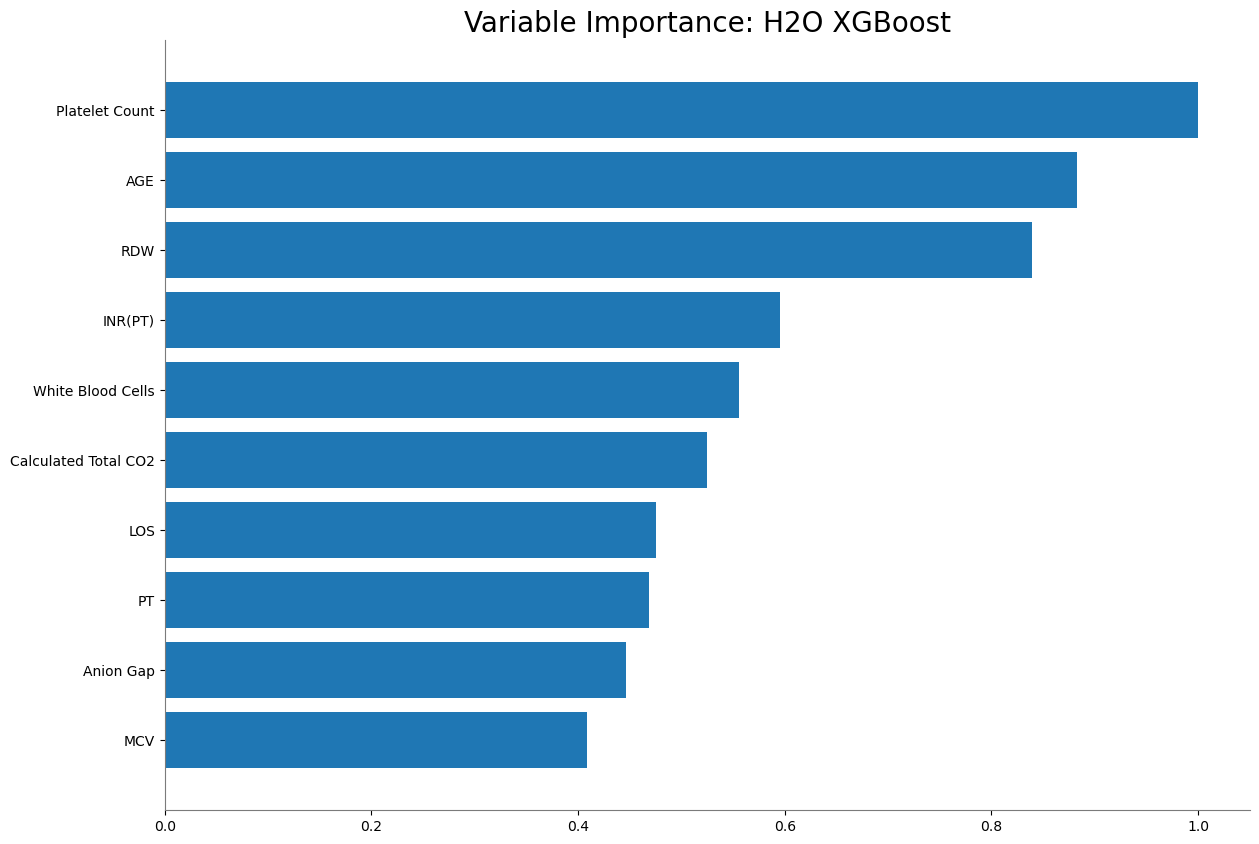

  predict
        0
        0
        0
        1
        1
        0
        0
        0
        0
        0
[1517 rows x 1 column]



/home/watercar99/.local/lib/python3.9/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'ETHNICITY' has levels not trained on: ["ASIAN - CAMBODIAN", "HISPANIC/LATINO - COLOMBIAN", "SOUTH AMERICAN"]
  warnings.warn(w)


H2OResponseError: Server error java.lang.IllegalArgumentException:
  Error: Column var1 not found
  Request: POST /99/Rapids
    data: {'ast': "(tmp= py_167_sid_af2d (cols_py py_159_sid_af2d 'var1'))", 'session_id': '_sid_af2d'}


<Figure size 640x480 with 0 Axes>

In [204]:
## 중요 변수 시각화
aml.leader.varimp_plot()

## automl 결과 확인
# Get AutoML object by `project_name`
get_aml = h2o.automl.get_automl(aml.project_name)
# Predict with top model from AutoML Leaderboard on a H2OFrame called 'test'
label_predicted = get_aml.predict(h2o_valid)
print(label_predicted['predict'])
print(h2o_valid['var1'])

In [205]:
data = pd.read_csv("~/project/MIMIC-III/Data/Demo+Lab_24h(50%).csv")
data

,SUBJECT_ID,HADM_ID,ETHNICITY,GENDER,AGE,LOS,TLOS,DOA,Hematocrit,Creatinine,...,Base Excess,Albumin,weight,height,hr_min,hr_mean,hr_max,Temperate,BMI,HOSPITAL_EXPIRE_FLAG
0,36,165660,WHITE,M,72,4.3483,10 days 01:46:00,NaN,41.850000,1.100,...,0.000000,0.0,105.3,180.0,67.0,85.0,105.0,0.000000,0.003250,0
1,91,121205,WHITE,F,81,3.9715,17 days 15:08:00,17 days 15:08:00,36.700000,0.750,...,0.000000,2.6,0.0,0.0,0.0,0.0,0.0,37.444401,0.000000,1
2,94,140037,ASIAN,M,75,22.8977,22 days 22:53:00,NaN,35.900000,0.250,...,14.000000,0.0,0.0,0.0,0.0,0.0,0.0,36.111099,0.000000,0
3,101,175533,ASIAN,M,82,9.8919,15 days 18:41:00,15 days 18:41:00,34.133333,0.925,...,-9.000000,0.0,0.0,0.0,0.0,0.0,0.0,36.888901,0.000000,1
4,111,192123,WHITE,F,66,10.5708,11 days 04:50:00,NaN,41.700000,0.600,...,-3.444444,0.0,0.0,0.0,0.0,0.0,0.0,35.611099,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7579,99897,181057,BLACK/HAITIAN,M,54,0.8342,5 days 00:02:00,NaN,31.250000,5.450,...,0.000000,0.0,0.0,0.0,67.0,74.0,95.0,0.000000,0.000000,0
7580,99899,188409,BLACK/AFRICAN AMERICAN,M,87,9.1439,9 days 01:34:00,9 days 01:34:00,20.050000,1.700,...,-3.000000,2.9,0.0,155.0,25.0,72.0,135.0,0.000000,0.000000,1
7581,99912,189380,WHITE,M,84,12.0867,13 days 21:35:00,NaN,37.600000,1.025,...,-5.666667,0.0,80.0,175.0,69.0,92.0,123.0,0.000000,0.002612,0
7582,99939,159023,HISPANIC OR LATINO,M,26,2.8780,11 days 10:59:00,NaN,22.220000,20.200,...,-1.333333,3.2,0.0,0.0,60.0,86.0,113.0,0.000000,0.000000,0


In [206]:
# data.drop(["SUBJECT_ID","HADM_ID", "DOA", "TLOS"], axis=1, inplace=True)
data.drop(["SUBJECT_ID","HADM_ID", "DOA", "TLOS", "height", "weight", "BMI", "hr_mean", "hr_min", "hr_max"], axis=1, inplace=True)
data

,ETHNICITY,GENDER,AGE,LOS,Hematocrit,Creatinine,Urea Nitrogen,Platelet Count,White Blood Cells,Hemoglobin,...,pH,Calculated Total CO2,pO2,pCO2,pH.1,Lactate,Base Excess,Albumin,Temperate,HOSPITAL_EXPIRE_FLAG
0,WHITE,M,72,4.3483,41.850000,1.100,19.500000,225.000000,16.65,14.450000,...,7.330000,28.000000,59.000000,50.000000,0.00,0.000000,0.000000,0.0,0.000000,0
1,WHITE,F,81,3.9715,36.700000,0.750,19.500000,381.000000,11.20,11.500000,...,0.000000,0.000000,0.000000,0.000000,5.00,0.000000,0.000000,2.6,37.444401,1
2,ASIAN,M,75,22.8977,35.900000,0.250,11.000000,384.000000,10.55,11.950000,...,7.397143,44.285714,150.571429,70.857143,8.00,1.466667,14.000000,0.0,36.111099,0
3,ASIAN,M,82,9.8919,34.133333,0.925,16.000000,223.666667,12.00,11.166667,...,7.278750,16.750000,132.250000,34.500000,5.25,5.825000,-9.000000,0.0,36.888901,1
4,WHITE,F,66,10.5708,41.700000,0.600,12.500000,145.500000,11.80,14.350000,...,7.241111,25.333333,153.222222,56.444444,5.00,1.100000,-3.444444,0.0,35.611099,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7579,BLACK/HAITIAN,M,54,0.8342,31.250000,5.450,60.833333,450.500000,14.65,10.000000,...,7.350000,28.000000,58.000000,48.000000,6.50,1.400000,0.000000,0.0,0.000000,0
7580,BLACK/AFRICAN AMERICAN,M,87,9.1439,20.050000,1.700,41.500000,227.500000,12.35,6.600000,...,7.355000,23.000000,211.500000,39.500000,7.00,1.800000,-3.000000,2.9,0.000000,1
7581,WHITE,M,84,12.0867,37.600000,1.025,22.250000,208.000000,4.00,12.233333,...,7.271429,20.500000,97.500000,40.000000,5.00,3.233333,-5.666667,0.0,0.000000,0
7582,HISPANIC OR LATINO,M,26,2.8780,22.220000,20.200,148.666667,100.600000,9.45,7.850000,...,7.380000,23.833333,134.000000,38.833333,6.25,1.400000,-1.333333,3.2,0.000000,0


In [207]:
data.columns

Index(['ETHNICITY', 'GENDER', 'AGE', 'LOS', 'Hematocrit', 'Creatinine',
       'Urea Nitrogen', 'Platelet Count', 'White Blood Cells', 'Hemoglobin',
       'MCHC', 'MCV', 'MCH', 'Red Blood Cells', 'RDW', 'Potassium', 'Chloride',
       'Bicarbonate', 'Sodium', 'Anion Gap', 'Glucose', 'Magnesium',
       'Calcium, Total', 'Phosphate', 'INR(PT)', 'PT', 'PTT', 'pH',
       'Calculated Total CO2', 'pO2', 'pCO2', 'pH.1', 'Lactate', 'Base Excess',
       'Albumin', 'Temperate', 'HOSPITAL_EXPIRE_FLAG'],
      dtype='object')

In [208]:
#### 1. h2o 분석 준비하기 ####
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
%matplotlib inline
h2o.init()
h2o.no_progress()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,58 mins 58 secs
H2O_cluster_timezone:,Asia/Seoul
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,3 months and 2 days
H2O_cluster_name:,H2O_from_python_watercar99_lu6qpu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,29.35 Gb
H2O_cluster_total_cores:,36
H2O_cluster_allowed_cores:,36
H2O_cluster_status:,"locked, healthy"


In [209]:
#### 2. 데이터 불러오기 ####
data.head()
# 데이터 확인
data.describe()

# var2~는 입력 feature
feature = data.drop('HOSPITAL_EXPIRE_FLAG', axis=1)
feature.describe()

# var1은 label
label = data['HOSPITAL_EXPIRE_FLAG']
label.describe()

count    7584.000000
mean        0.256461
std         0.436708
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: HOSPITAL_EXPIRE_FLAG, dtype: float64

In [210]:
## make dataset
# Identify the response and set of predictors
y = "HOSPITAL_EXPIRE_FLAG"
x = list(data.columns)  #if x is defined as all columns except the response, then x is not required
x.remove(y)

# data_df을 8:2로 나눈다
train, valid = train_test_split(data,test_size=0.2, shuffle=True)

In [211]:
h2o_train = h2o.H2OFrame(train)
h2o_valid = h2o.H2OFrame(valid)

# For binary classification, response should be a factor
h2o_train[y] = h2o_train[y].asfactor()
h2o_valid[y] = h2o_valid[y].asfactor()

In [212]:
################################################################    
## Run AutoML for 120 seconds
aml = H2OAutoML(max_runtime_secs=120, exclude_algos =['StackedEnsemble'])
aml.train(x = x, y = y, training_frame=h2o_train, leaderboard_frame=h2o_valid)

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_2_AutoML_13_20230511_115916


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    38                 38                          35590                  7            7            7             35            92            68.2105

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.08983095242837329
RMSE: 0.29971812162158845
LogLoss: 0.31392204466586016
Mean Per-Class Error: 0.11351093387029387
AUC: 0.9605970464685545
AUCPR: 0.9215746370667541
Gini: 0.921194092937109

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3455563681523314
       0     1     Error    Rate
-----  ----  ----  -------  --------------
0      4315  211   0.0466   (211.0/4526.0)
1      278   1263  0.1804   (278.0/1541.0)
Total  4593  1474  0.0806   (489.0/6067.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.345556     0.837811  190
max f2                       0.26081      0.86422   235
max f0point5                 0.420606     0.882592  159
max accuracy                 0.365617     0.920719  182
max precision                0.958256     1         0
max recall                   0.0812145    1         360
max specificity              0.958256     1         0
max absolute_mcc             0.360024     0.785639  184
max min_per_class_accuracy   0.288599     0.891958  219
max mean_per_class_accuracy  0.290389     0.892573  218
max tns                      0.958256     4526      0
max fns                      0.958256     1540      0
max fps                      0.0244752    4526      399
max tps                      0.0812145    1541      360
max tnr                      0.958256     1         0
max fnr                      0.958256     0.999351  0
max fpr                      0.0244752    1         399
max tpr                      0.0812145    1         360

Gains/Lift Table: Avg response rate: 25.40 %, avg score: 25.43 %
group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ----------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100544                   0.843968           3.93705     3.93705            1                0.884078   1                           0.884078            0.0395847       0.0395847                  293.705   293.705            0.0395847
2        0.0201088                   0.795542           3.93705     3.93705            1                0.821917   1                           0.852997            0.0395847       0.0791694                  293.705   293.705            0.0791694
3        0.0299984                   0.76563            3.93705     3.93705            1                0.779308   1                           0.828704            0.0389358       0.118105                   293.705   293.705            0.118105
4        0.0400527                   0.737846           3.93705     3.93705            1                0.750101   1                           0.808973            0.0395847       0.15769                    293.705   293.705            0.15769
5        0.0501071                   0.712843           3.93705     3.93705            1                0.724815   1                  

In [213]:
leaderboard = aml.leaderboard
performance = aml.leader.model_performance(h2o_valid)  # (Optional) Evaluate performance on a test set

model_id   =aml.leader.model_id  # 최고 모델 명
accuracy   =performance.accuracy()  # 정확도
precision  =performance.precision()  # precision
recall     =performance.recall()  # recall
F1         =performance.F1()  # f1
auc        =performance.auc()  # auc
variable_importance=aml.leader.varimp()  # 중요한 입력 변수

print(model_id, accuracy, precision, recall, F1, auc, variable_importance)
print(performance)

GBM_2_AutoML_13_20230511_115916 [[0.5239755697808668, 0.7679630850362558]] [[0.9033606767285287, 1.0]] [[0.04141357168442557, 1.0]] [[0.2983875536673776, 0.5131729667812142]] 0.7269699678862765 [('RDW', 270.7117614746094, 1.0, 0.09233836150104126), ('AGE', 223.60987854003906, 0.8260072533310006, 0.0762721563605601), ('ETHNICITY', 169.37225341796875, 0.6256553187618135, 0.05777198699887754), ('LOS', 163.11923217773438, 0.6025568718891205, 0.055639114261434225), ('Platelet Count', 135.20249938964844, 0.49943341454090967, 0.04611686317757791), ('Lactate', 121.02983093261719, 0.44708006136618794, 0.04128264032633877), ('INR(PT)', 111.76649475097656, 0.4128616139253313, 0.03812296495654058), ('Albumin', 96.97981262207031, 0.3582401152199893, 0.03307930526335804), ('White Blood Cells', 89.23802947998047, 0.3296422327345031, 0.030438623652248923), ('pCO2', 88.63479614257812, 0.3274139093911934, 0.03023286392583319), ('PT', 82.81996154785156, 0.3059341090195648, 0.02824945435414754), ('Urea Ni

In [214]:
for i in variable_importance:
    print(i)

('RDW', 270.7117614746094, 1.0, 0.09233836150104126)
('AGE', 223.60987854003906, 0.8260072533310006, 0.0762721563605601)
('ETHNICITY', 169.37225341796875, 0.6256553187618135, 0.05777198699887754)
('LOS', 163.11923217773438, 0.6025568718891205, 0.055639114261434225)
('Platelet Count', 135.20249938964844, 0.49943341454090967, 0.04611686317757791)
('Lactate', 121.02983093261719, 0.44708006136618794, 0.04128264032633877)
('INR(PT)', 111.76649475097656, 0.4128616139253313, 0.03812296495654058)
('Albumin', 96.97981262207031, 0.3582401152199893, 0.03307930526335804)
('White Blood Cells', 89.23802947998047, 0.3296422327345031, 0.030438623652248923)
('pCO2', 88.63479614257812, 0.3274139093911934, 0.03023286392583319)
('PT', 82.81996154785156, 0.3059341090195648, 0.02824945435414754)
('Urea Nitrogen', 82.79806518554688, 0.3058532246051403, 0.028241985619848614)
('Calcium, Total', 80.92769622802734, 0.29894414556353777, 0.02760401258166585)
('Anion Gap', 76.09888458251953, 0.2811066802860614, 0.0

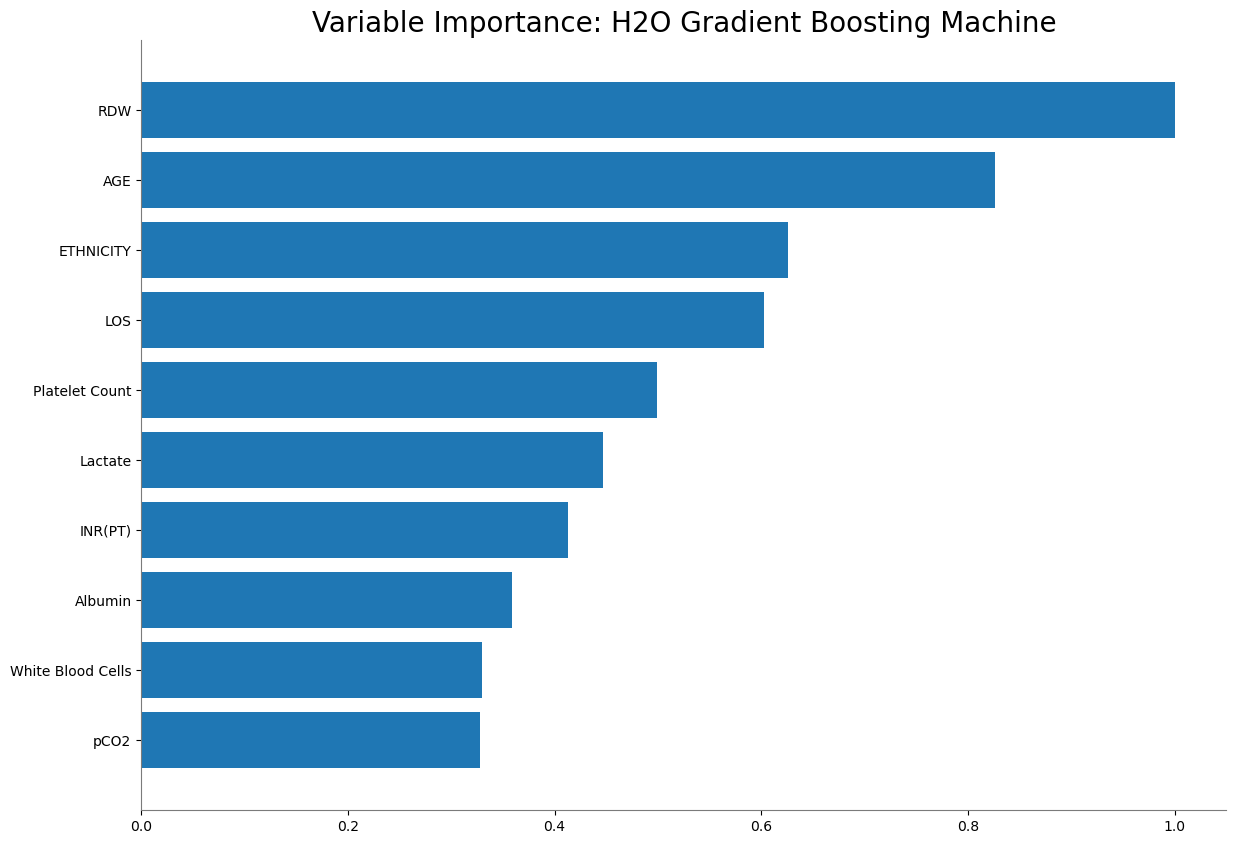

  predict
        0
        1
        1
        1
        0
        0
        0
        0
        0
        1
[1517 rows x 1 column]



/home/watercar99/.local/lib/python3.9/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'ETHNICITY' has levels not trained on: ["ASIAN - JAPANESE", "HISPANIC/LATINO - COLOMBIAN", "MIDDLE EASTERN"]
  warnings.warn(w)


H2OResponseError: Server error java.lang.IllegalArgumentException:
  Error: Column var1 not found
  Request: POST /99/Rapids
    data: {'ast': "(tmp= py_177_sid_9947 (cols_py py_169_sid_9947 'var1'))", 'session_id': '_sid_9947'}


<Figure size 640x480 with 0 Axes>

In [215]:
## 중요 변수 시각화
aml.leader.varimp_plot()

## automl 결과 확인
# Get AutoML object by `project_name`
get_aml = h2o.automl.get_automl(aml.project_name)
# Predict with top model from AutoML Leaderboard on a H2OFrame called 'test'
label_predicted = get_aml.predict(h2o_valid)
print(label_predicted['predict'])
print(h2o_valid['var1'])